### Index
1. [PCA plot of the log transformed raw expression data](#PCA-plot-of-the-log-transformed-raw-expression-data)
2. [Boxplot of log2 intensities for the raw data](#Boxplot-of-log2-intensities-for-the-raw-data)
3. [PCA plot of the calibrated, summarized on exon level data](#PCA-plot-of-the-calibrated,-summarized-on-exon-level-data)
4. [Histogram of the median intensities](#Histogram-of-the-median-intensities)
5. [Cut off for median intensities](#Cut-off-for-median-intensities)
6. [Distrubution of expression values](#Distrubution-of-expression-values)
7. [Heatmap](#Heatmap)
8. [DE genes for background matching](#DE-genes-for-background-matching)
9. [Enrichment analysis](#Enrichment-analysis)

### GeneChip® Mouse Exon 1.0 ST Array (Mouse Transcriptome Assay 1.0)
>With approximately four probes per exon and roughly 40 probes per gene, the GeneChip® Mouse Exon 1.0 ST Array enables two complementary levels of analysis—gene expression and alternative splicing.
Multiple probes per exon enable "exon-level" analysis and allow you to distinguish between different isoforms of a gene. This exon-level analysis on a whole-genome scale opens the door to detecting specific alterations in exon usage that may play a central role in disease mechanism and etiology.
The second level is "gene-level" expression analysis, in which multiple probes on different exons are summarized into an expression value of all transcripts from the same gene.
Exon arrays provide the most comprehensive coverage of the genome, including empirically supported and predicted transcribed sequences, enabling the discovery of previously unidentified novel events.

In [219]:
# Turn warnings off for installation for notebook display
options(warn=-1)

In [217]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install()
install.packages("devtools")
library(devtools)
install_github("r-lib/remotes")
library(remotes)
library(pd.mta.1.0)
library(mta10probeset.db)
library(oligo)
library(limma)
library(dplyr)
library(ggplot2)
install.packages("plotly")
library(plotly)
library(geneplotter)
library(RColorBrewer)
library(pheatmap)
install.packages("Rtsne")
library(Rtsne)
install_github("wjawaid/enrichR")
library(enrichR)

In [220]:
# Turn warnings on
options(warn=0)

In [16]:
setwd("CEL_files")

In [17]:
cel_files<-list.celfiles()

Read manaully created description file

In [19]:
SDRF <- read.delim("DH5881.sdrf.txt")

In [20]:
rownames(SDRF) <- SDRF$Array.Data.File

In [21]:
SDRF <- AnnotatedDataFrame(SDRF)

In [22]:
SDRF$Array.Data.File

[1] DH5881-CLMD_Mo-8.1.CEL DH5881-CLMD_Mo-8.2.CEL DH5881-CLMD_Mo-8.3.CEL
[4] DH5881-CLMD_Mo-8.4.CEL DH5881-CLMD_Mo-8.5.CEL DH5881-CLMD_Mo-8.6.CEL
[7] DH5881-CLMD_Mo-8.7.CEL DH5881-CLMD_Mo-8.8.CEL
8 Levels: DH5881-CLMD_Mo-8.1.CEL ... DH5881-CLMD_Mo-8.8.CEL

In [23]:
raw_data <- oligo::read.celfiles(filenames = file.path(".", SDRF$Array.Data.File), verbose = FALSE, phenoData = SDRF)

Reading in : ./DH5881-CLMD_Mo-8.1.CEL
Reading in : ./DH5881-CLMD_Mo-8.2.CEL
Reading in : ./DH5881-CLMD_Mo-8.3.CEL
Reading in : ./DH5881-CLMD_Mo-8.4.CEL
Reading in : ./DH5881-CLMD_Mo-8.5.CEL
Reading in : ./DH5881-CLMD_Mo-8.6.CEL
Reading in : ./DH5881-CLMD_Mo-8.7.CEL
Reading in : ./DH5881-CLMD_Mo-8.8.CEL


Warning message in oligo::read.celfiles(filenames = file.path(".", SDRF$Array.Data.File), :
“'channel' automatically added to varMetadata in phenoData.”

In [24]:
head(Biobase::pData(raw_data))

,Source.Name,Individual,Organism,Phenotype,Array.Data.File,X
,<fct>,<dbl>,<fct>,<fct>,<fct>,<lgl>
DH5881-CLMD_Mo-8.1.CEL,C1 RNA d8,8.1,Mus musculus,control,DH5881-CLMD_Mo-8.1.CEL,NA
DH5881-CLMD_Mo-8.2.CEL,C2 RNA d8,8.2,Mus musculus,control,DH5881-CLMD_Mo-8.2.CEL,NA
DH5881-CLMD_Mo-8.3.CEL,C3 RNA d8,8.3,Mus musculus,control,DH5881-CLMD_Mo-8.3.CEL,NA
DH5881-CLMD_Mo-8.4.CEL,C4 RNA d8,8.4,Mus musculus,control,DH5881-CLMD_Mo-8.4.CEL,NA
DH5881-CLMD_Mo-8.5.CEL,HL1 RNA d8,8.5,Mus musculus,helpless,DH5881-CLMD_Mo-8.5.CEL,NA
DH5881-CLMD_Mo-8.6.CEL,HL2 RNA d8,8.6,Mus musculus,helpless,DH5881-CLMD_Mo-8.6.CEL,NA


Following protocol from https://bioconductor.org/packages/devel/workflows/vignettes/maEndToEnd/inst/doc/MA-Workflow.html#14_a_pathway_enrichment_analysis_using_reactome

In [25]:
Biobase::exprs(raw_data)[1:5, 1:5]

DH5881-CLMD_Mo-8.1.CEL,DH5881-CLMD_Mo-8.2.CEL,DH5881-CLMD_Mo-8.3.CEL,DH5881-CLMD_Mo-8.4.CEL,DH5881-CLMD_Mo-8.5.CEL
4115,5152,5532,3941,5077
188,227,192,155,250
4505,5422,5370,4304,5010
164,149,145,130,183
178,158,145,148,165


In [26]:
exp_raw <- log2(Biobase::exprs(raw_data))

In [27]:
PCA_raw <- prcomp(t(exp_raw), scale. = FALSE)

In [28]:
percentVar <- round(100*PCA_raw$sdev^2/sum(PCA_raw$sdev^2),1)

In [29]:
sd_ratio <- sqrt(percentVar[2] / percentVar[1])

In [30]:
dataGG <- data.frame(PC1 = PCA_raw$x[,1], PC2 = PCA_raw$x[,2],
                    Phenotype = pData(raw_data)$Phenotype,
                    Individual = pData(raw_data)$Individual)

### PCA plot of the log-transformed raw expression data

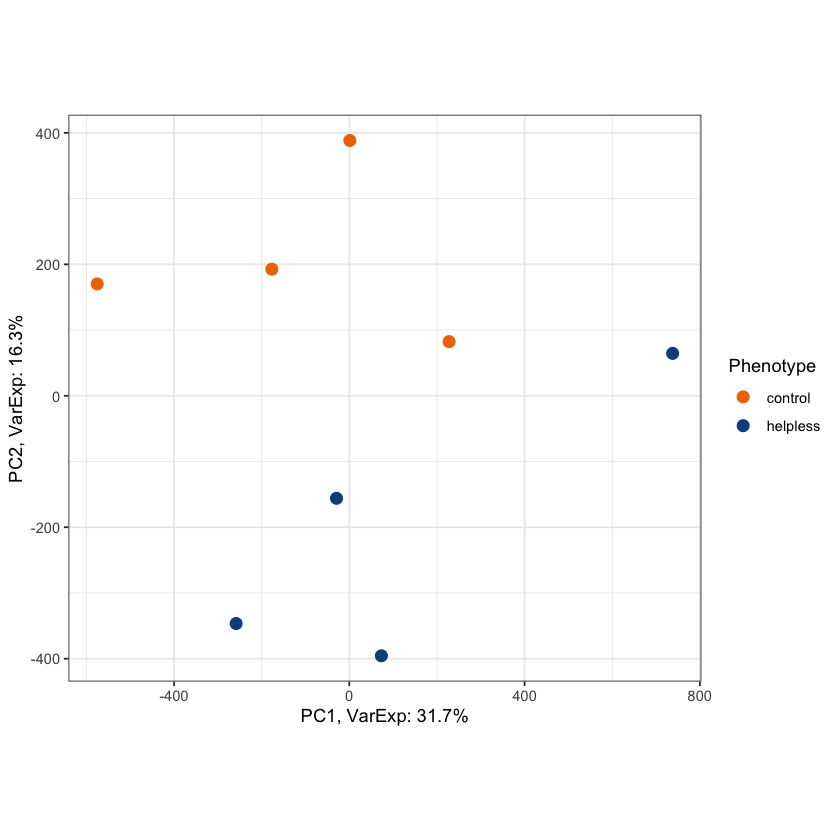

In [69]:
ggplot(dataGG, aes(PC1, PC2)) +
    geom_point(aes(colour = Phenotype), size=3) +
    xlab(paste0("PC1, VarExp: ", percentVar[1], "%")) +
    ylab(paste0("PC2, VarExp: ", percentVar[2], "%")) +
    theme(plot.title = element_text(hjust = 0.5)) +
    theme_bw() +
    coord_fixed(ratio = 1.5) +
    scale_shape_manual(values = c(4,15)) + 
    scale_color_manual(values = c("darkorange2", "dodgerblue4"))

### Boxplot of log2-intensities for the raw data

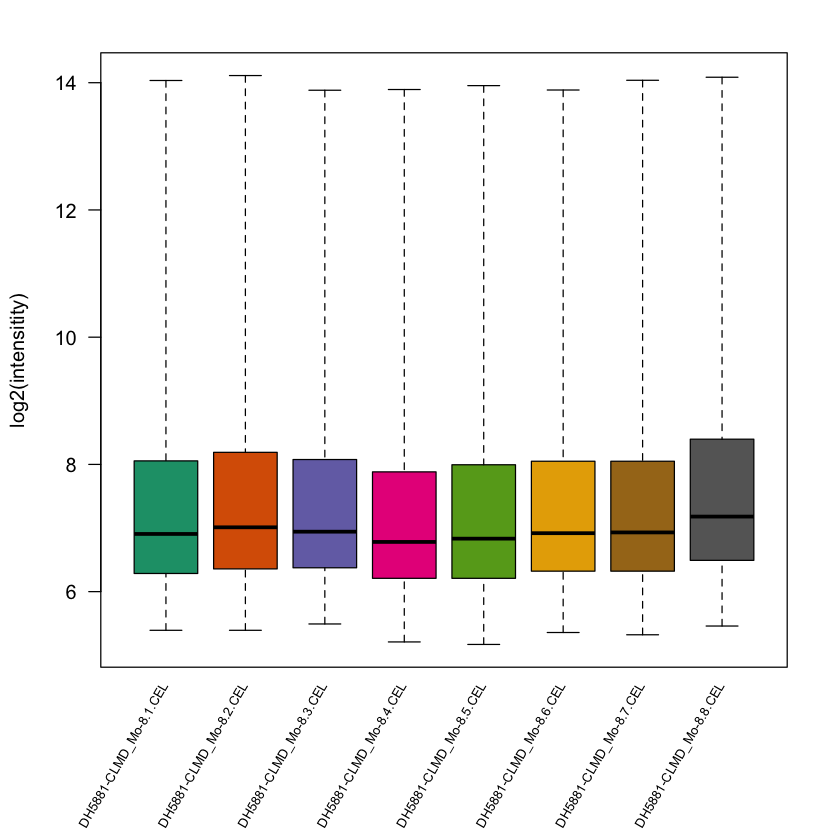

In [57]:
par(mar = c(7, 4, 2, 2) + 0.2)
oligo::boxplot(raw_data, target = "probeset",
               ylab="log2(intensitity)",
               xlab=element_blank(),
               las=2,
               main=element_blank(),
               xaxt="n")
end_point = 0.5 + nrow(Biobase::pData(raw_data))
text(seq(1,end_point,by=1), par("usr")[3]-0.25, 
     srt = 60, adj= 1, xpd = TRUE,
     labels = paste(rownames(Biobase::pData(raw_data))), cex=0.65)

In [58]:
palmieri_eset <- oligo::rma(raw_data, target = "probeset", normalize = FALSE)

Background correcting
Calculating Expression


In [59]:
row_medians_assayData <- Biobase::rowMedians(as.matrix(Biobase::exprs(palmieri_eset)))

In [60]:
RLE_data <- sweep(Biobase::exprs(palmieri_eset), 1, row_medians_assayData)

In [61]:
RLE_data <- as.data.frame(RLE_data)

In [62]:
RLE_data_gathered <- tidyr::gather(RLE_data, samples, log2_expression_deviation)

In [ ]:
## Histogram 

Warning message:
“Removed 1706 rows containing non-finite values (stat_boxplot).”

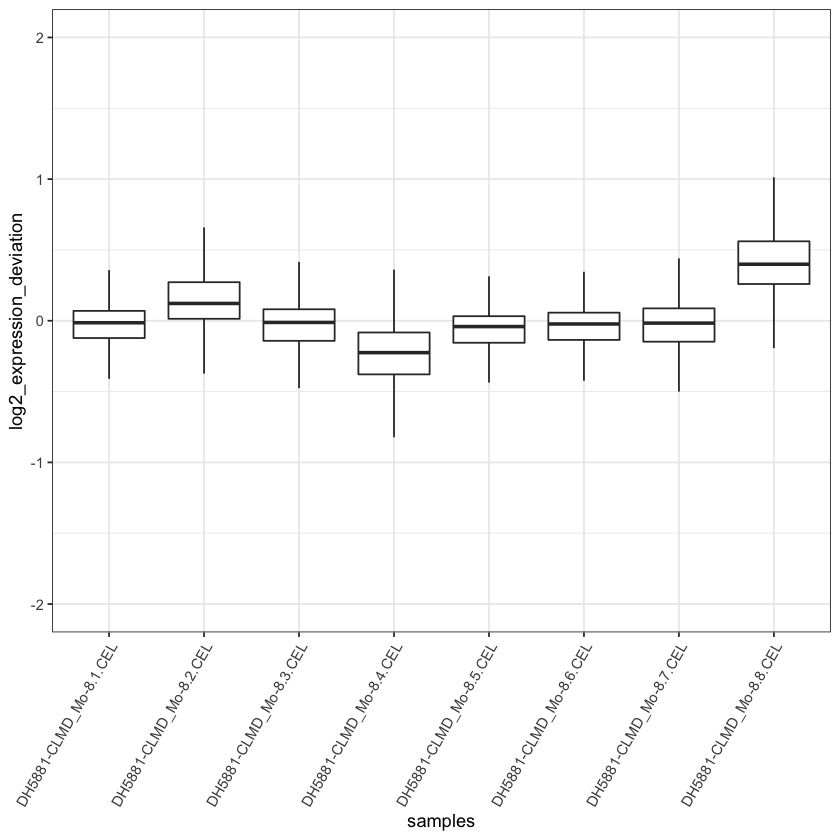

In [63]:
ggplot2::ggplot(RLE_data_gathered, aes(samples,
    log2_expression_deviation)) + 
    geom_boxplot(outlier.shape = NA) + 
    ylim(c(-2, 2)) + 
    theme_bw() +
    theme(axis.text.x = element_text(angle = 60, hjust = 1))

In [64]:
palmieri_eset_norm_exon <- oligo::rma(raw_data, target = "probeset")

Background correcting
Normalizing
Calculating Expression


In [65]:
exp_palmieri_exon <- Biobase::exprs(palmieri_eset_norm_exon)
PCA_exon <- prcomp(t(exp_palmieri_exon), scale = FALSE)

In [66]:
PCA_exon$x

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
DH5881-CLMD_Mo-8.1.CEL,-87.93702,57.18142,-44.870593,111.89531,-19.15954,-101.995002,36.086108,2.754098e-12
DH5881-CLMD_Mo-8.2.CEL,-30.30214,-126.23799,-61.413835,83.26534,54.36754,68.739152,-40.433596,1.074440e-12
DH5881-CLMD_Mo-8.3.CEL,-134.34347,7.36091,-98.668324,-114.43501,-64.64202,7.044587,-32.310929,2.065658e-12
DH5881-CLMD_Mo-8.4.CEL,-174.47719,-12.48496,154.705156,-22.90856,29.80577,10.832524,12.291510,3.589488e-12
DH5881-CLMD_Mo-8.5.CEL,100.90004,49.18302,45.428916,50.75131,-118.25964,82.011022,1.270825,1.180416e-12
DH5881-CLMD_Mo-8.6.CEL,89.77378,125.11023,1.373088,-16.29900,87.99423,-2.367912,-86.044994,3.783857e-13
DH5881-CLMD_Mo-8.7.CEL,154.04483,-110.69399,40.995923,-42.78408,-27.19298,-95.120767,-22.851554,-6.426498e-13
DH5881-CLMD_Mo-8.8.CEL,82.34117,10.58137,-37.550330,-49.48531,57.08663,30.856396,131.992629,-1.016384e-11


In [67]:
tsne <- Rtsne(PCA_exon$x, dims = 3, perplexity=2, verbose=TRUE, max_iter = 500)

Performing PCA
Read the 8 x 8 data matrix successfully!
OpenMP is working. 1 threads.
Using no_dims = 3, perplexity = 2.000000, and theta = 0.500000
Computing input similarities...
Building tree...
Done in 0.00 seconds (sparsity = 0.843750)!
Learning embedding...
Iteration 50: error is 48.255690 (50 iterations in 0.00 seconds)
Iteration 100: error is 46.137621 (50 iterations in 0.00 seconds)
Iteration 150: error is 52.026929 (50 iterations in 0.00 seconds)
Iteration 200: error is 48.865998 (50 iterations in 0.00 seconds)
Iteration 250: error is 40.888686 (50 iterations in 0.00 seconds)
Iteration 300: error is 0.932895 (50 iterations in 0.00 seconds)
Iteration 350: error is 0.198933 (50 iterations in 0.00 seconds)
Iteration 400: error is 0.138217 (50 iterations in 0.00 seconds)
Iteration 450: error is 0.129326 (50 iterations in 0.00 seconds)
Iteration 500: error is 0.121468 (50 iterations in 0.00 seconds)
Fitting performed in 0.00 seconds.


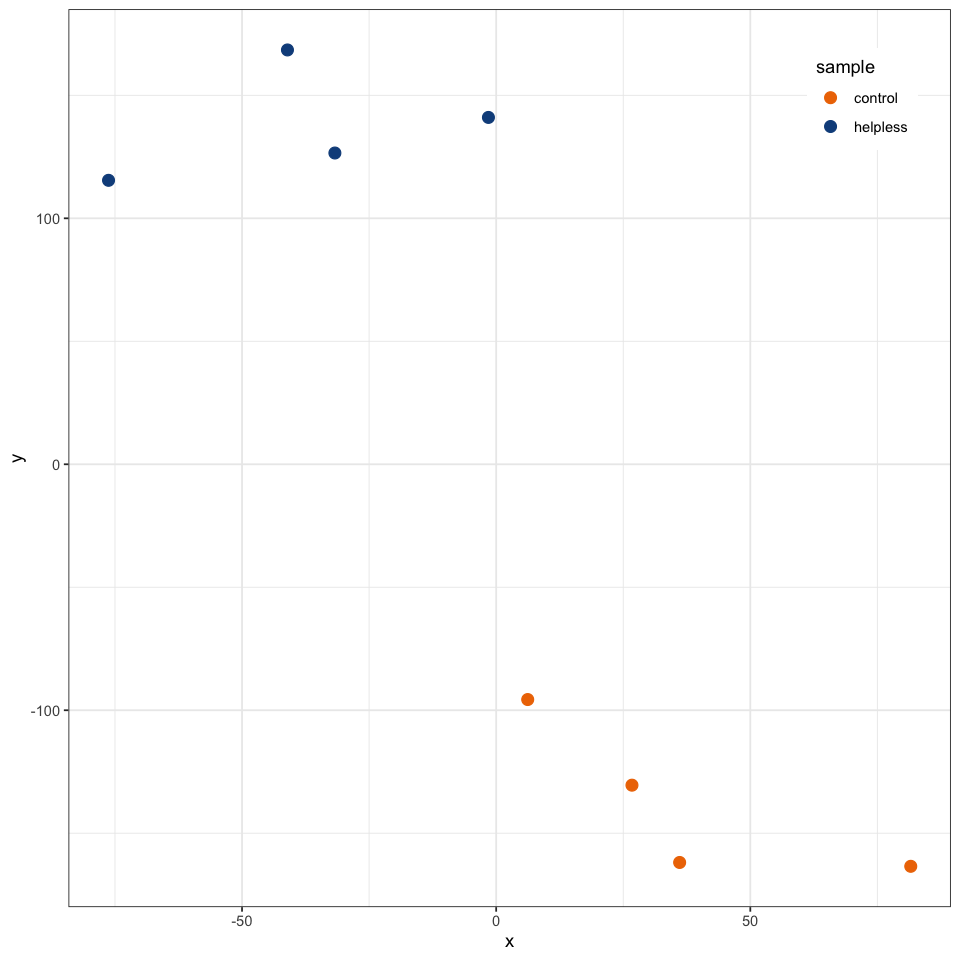

In [222]:
tsne_plot <- data.frame(x = tsne$Y[,1], y = tsne$Y[,2], sample=c(rep("control", 4), rep("helpless", 4)))
ggplot(tsne_plot) + geom_point(aes(x=x, y=y, color=sample), size=3) +
    theme_bw() +
    theme(legend.position = c(0.9, 0.9)) + 
    scale_color_manual(values = c("darkorange2", "dodgerblue4"))

### PCA plot of the calibrated, summarized on exon level data

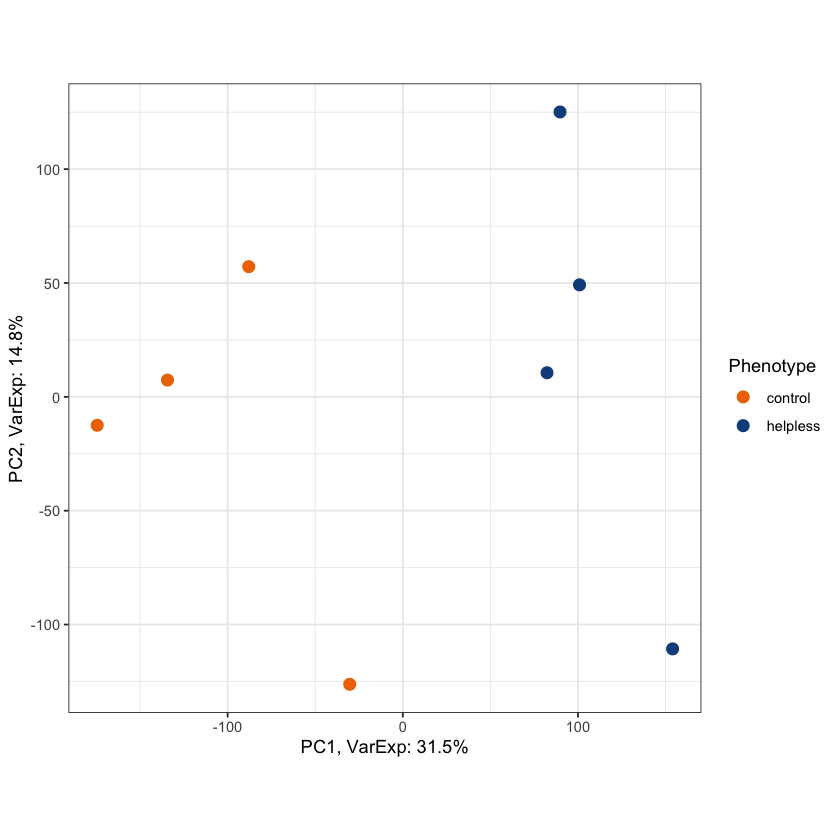

In [77]:
percentVar_exon <- round(100*PCA_exon$sdev^2/sum(PCA_exon$sdev^2),1)
sd_ratio <- sqrt(percentVar_exon[2] / percentVar_exon[1])

dataGG_exon <- data.frame(PC1 = PCA_exon$x[,1], PC2 = PCA_exon$x[,2],
                    Phenotype = 
                     Biobase::pData(palmieri_eset_norm_exon)$Phenotype)

ggplot(dataGG_exon, aes(PC1, PC2)) +
    geom_point(aes(colour = Phenotype), size=3) +
    xlab(paste0("PC1, VarExp: ", percentVar_exon[1], "%")) +
    ylab(paste0("PC2, VarExp: ", percentVar_exon[2], "%")) +
    theme(plot.title = element_text(hjust = 0.5)) +
    theme_bw()+
    coord_fixed(ratio = 1.3) +
    scale_shape_manual(values = c(4,15)) + 
    scale_color_manual(values = c("darkorange2", "dodgerblue4"))

In [78]:
annotation_for_heatmap <- data.frame(Phenotype = pData(palmieri_eset_norm_exon)$Phenotype)

In [79]:
row.names(annotation_for_heatmap) <- row.names(pData(palmieri_eset_norm_exon))

In [80]:
dists <- as.matrix(dist(t(exp_palmieri_exon), method = "manhattan"))

In [81]:
palmieri_medians <- rowMedians(Biobase::exprs(palmieri_eset_norm_exon))

## Histogram of the median intensities

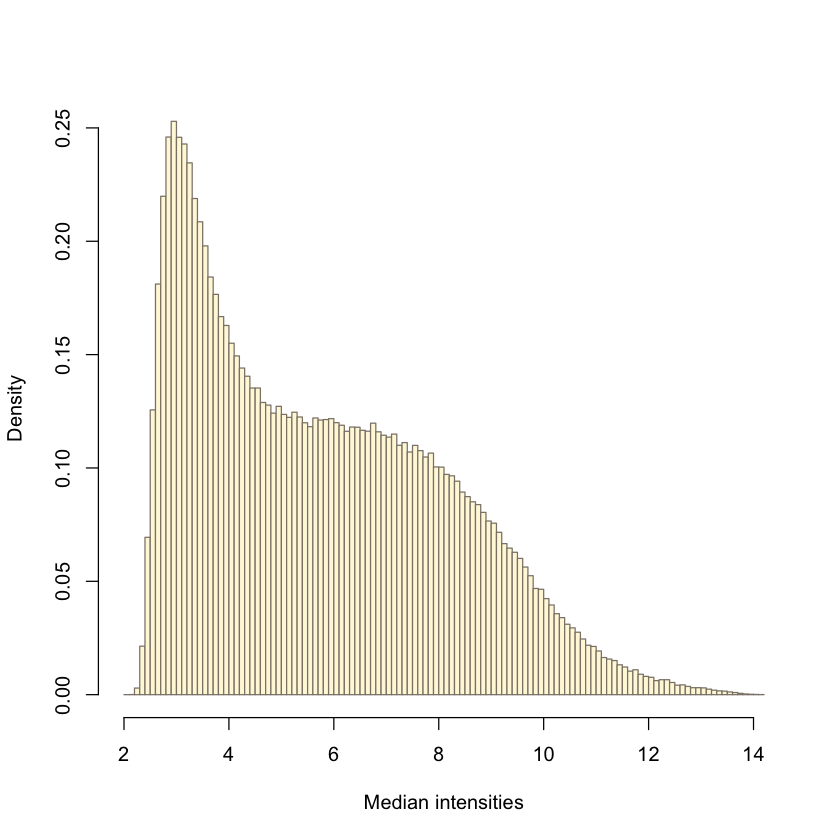

In [87]:
hist_res <- hist(palmieri_medians, 100, col = "cornsilk1", freq = FALSE,  
            border = "antiquewhite4",
            main = element_blank(),
            xlab = "Median intensities")

## Cut-off for median intensities
Intensity-based filtering based on `limma` recommendations - removing low intensity low variance probes

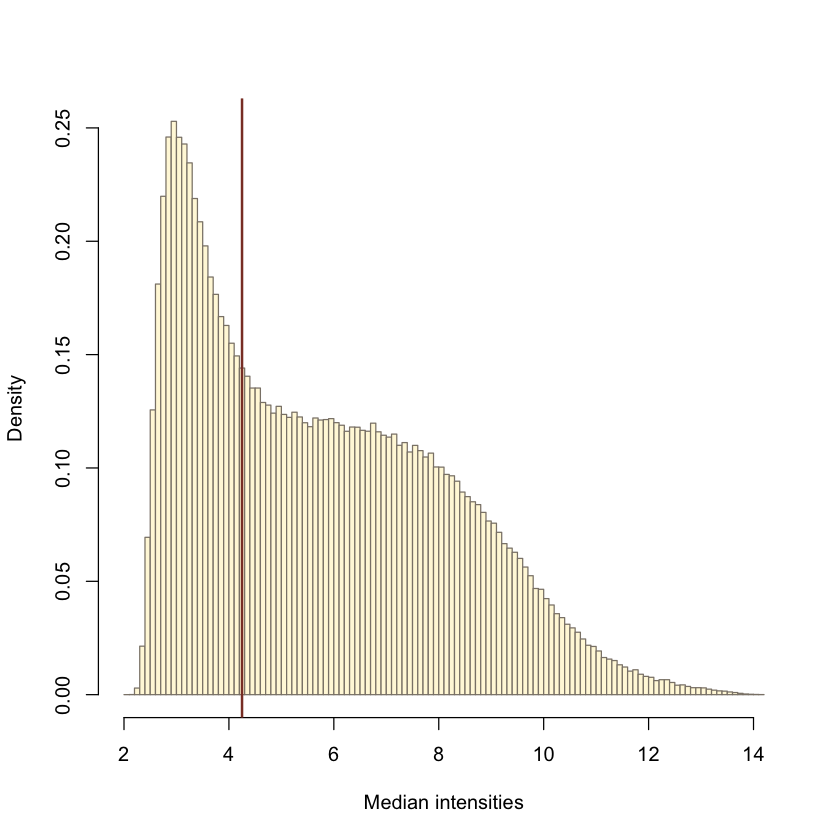

In [88]:
man_threshold <- 4.25

hist_res <- hist(palmieri_medians, 100, col = "cornsilk", freq = FALSE, 
            main = element_blank(),
            border = "antiquewhite4",
            xlab = "Median intensities")

abline(v = man_threshold, col = "coral4", lwd = 2)

In [89]:
no_of_samples <- table(paste0(pData(palmieri_eset_norm_exon)$Phenotype))
no_of_samples 


 control helpless 
       4        4 

In [90]:
samples_cutoff <- min(no_of_samples)

idx_man_threshold <- apply(Biobase::exprs(palmieri_eset_norm_exon), 1,
                           function(x){
                          sum(x > man_threshold) >= samples_cutoff})
                          table(idx_man_threshold)

idx_man_threshold
 FALSE   TRUE 
255415 479501 

In [91]:
palmieri_manfiltered <- subset(palmieri_eset_norm_exon, idx_man_threshold)

## Probe-based annotation for MTA 1.0

In [92]:
anno_palmieri <- AnnotationDbi::select(mta10probeset.db,
                                  keys = (featureNames(palmieri_manfiltered)),
                                  columns = c("SYMBOL", "GENENAME"),
                                  keytype = "PROBEID")

'select()' returned 1:many mapping between keys and columns


In [93]:
anno_palmieri <- subset(anno_palmieri, !is.na(SYMBOL))

In [94]:
anno_grouped <- group_by(anno_palmieri, PROBEID)
anno_summarized <- dplyr::summarize(anno_grouped, no_of_matches = n_distinct(SYMBOL))
anno_filtered <- filter(anno_summarized, no_of_matches > 1)
probe_stats <- anno_filtered 
dim(probe_stats)

[1] 3214    2

In [95]:
ids_to_exlude <- (featureNames(palmieri_manfiltered) %in% probe_stats$PROBEID)
table(ids_to_exlude)

ids_to_exlude
 FALSE   TRUE 
476287   3214 

In [96]:
palmieri_final <- subset(palmieri_manfiltered, !ids_to_exlude)
dim(palmieri_final)

Features  Samples 
  476287        8

In [97]:
fData(palmieri_final)$PROBEID <- rownames(fData(palmieri_final))
fData(palmieri_final) <- left_join(fData(palmieri_final), anno_palmieri)
rownames(fData(palmieri_final)) <- fData(palmieri_final)$PROBEID

Joining, by = "PROBEID"


In [98]:
individual <- as.character(Biobase::pData(palmieri_final)$Individual)
phenotype = pData(palmieri_eset_norm_exon)$Phenotype
design_palmieri <- model.matrix(~ 0 + phenotype)
colnames(design_palmieri)[1:2] <- c("control", "helpless")
rownames(design_palmieri) <- individual

In [99]:
contrast_matrix <- makeContrasts(control-helpless, levels = design_palmieri)

In [100]:
palmieri_fit <- eBayes(contrasts.fit(lmFit(palmieri_final, design = design_palmieri), contrast_matrix))

In [101]:
table <- topTable(palmieri_fit, number = Inf)
head(table)
nrow(subset(table, P.Value < 0.001))

,PROBEID,SYMBOL,GENENAME,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
JUC0200000877.mm.1,JUC0200000877.mm.1,Il1rn,interleukin 1 receptor antagonist,2.785488,5.258402,26.76548,4.823018e-10,0.0002297141,11.320564
JUC1700009774.mm.1,JUC1700009774.mm.1,Cfb,complement factor B,3.692280,5.980488,24.33643,1.144711e-09,0.0002726055,10.896099
JUC0200010616.mm.1,JUC0200010616.mm.1,Cd40,CD40 antigen,2.444325,4.906347,21.71068,3.219806e-09,0.0005111840,10.329735
JUC0200022781.mm.1,JUC0200022781.mm.1,Sulf2,sulfatase 2,2.829965,5.343452,19.38779,8.937749e-09,0.0006906624,9.708116
PSR1700018237.mm.1,PSR1700018237.mm.1,Cfb,complement factor B,2.098927,7.215938,18.98025,1.082035e-08,0.0006906624,9.584934
JUC0500018133.mm.1,JUC0500018133.mm.1,Flt1,FMS-like tyrosine kinase 1,2.587111,4.921796,18.57306,1.314922e-08,0.0006906624,9.457135


[1] 8825

In [102]:
volcano_names <- ifelse(abs(palmieri_fit$coefficients)>=1, palmieri_fit$genes$SYMBOL, NA)

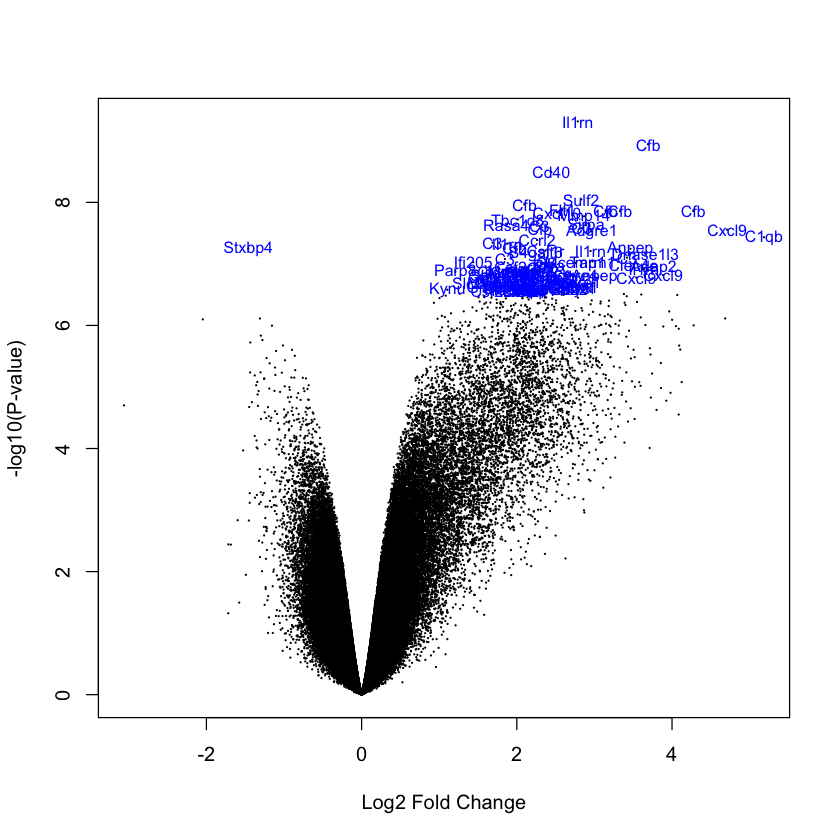

In [103]:
volcanoplot(palmieri_fit, coef = 1L, style = "p-value", highlight = 100, 
            names = volcano_names,
            xlab = "Log2 Fold Change", ylab = NULL, pch=16, cex=0.25)

In [136]:
DE_genes <- subset(table, adj.P.Val < 0.01)$PROBEID

In [157]:
DE_probes<-subset(exp_palmieri_exon, rownames(exp_palmieri_exon)%in%DE_genes)
row.names(DE_probes)<-mapIds(mta10probeset.db, 
      keys = rownames(DE_probes), 
      keytype = "PROBEID",
      column = "SYMBOL")

'select()' returned 1:1 mapping between keys and columns


In [138]:
head(DE_probes)
dim(DE_probes)

,DH5881-CLMD_Mo-8.1.CEL,DH5881-CLMD_Mo-8.2.CEL,DH5881-CLMD_Mo-8.3.CEL,DH5881-CLMD_Mo-8.4.CEL,DH5881-CLMD_Mo-8.5.CEL,DH5881-CLMD_Mo-8.6.CEL,DH5881-CLMD_Mo-8.7.CEL,DH5881-CLMD_Mo-8.8.CEL
Ly96,6.498908,6.003929,6.215526,6.449868,5.131434,5.003853,5.002140,5.552447
Tfap2d,5.556714,4.756430,5.054698,5.309663,6.344843,6.335846,6.598170,6.316815
Dst,5.810392,5.484278,5.398253,5.732689,4.734357,4.642704,4.549382,4.631992
Stat1,8.721595,8.712888,8.647198,8.714972,7.848012,7.830846,8.131137,8.070244
Sgo2a,6.154821,6.532704,6.462509,6.174416,7.213086,7.032449,7.078044,7.129298
Bmpr2,8.862426,8.892807,9.322889,9.369148,7.892115,8.228051,8.006053,8.212680


[1] 3439    8

In [139]:
length(unique(rownames(DE_probes)))

[1] 665

## Distrubution of expression values
Check distrubution of expression values to decide what function to use for collapsing

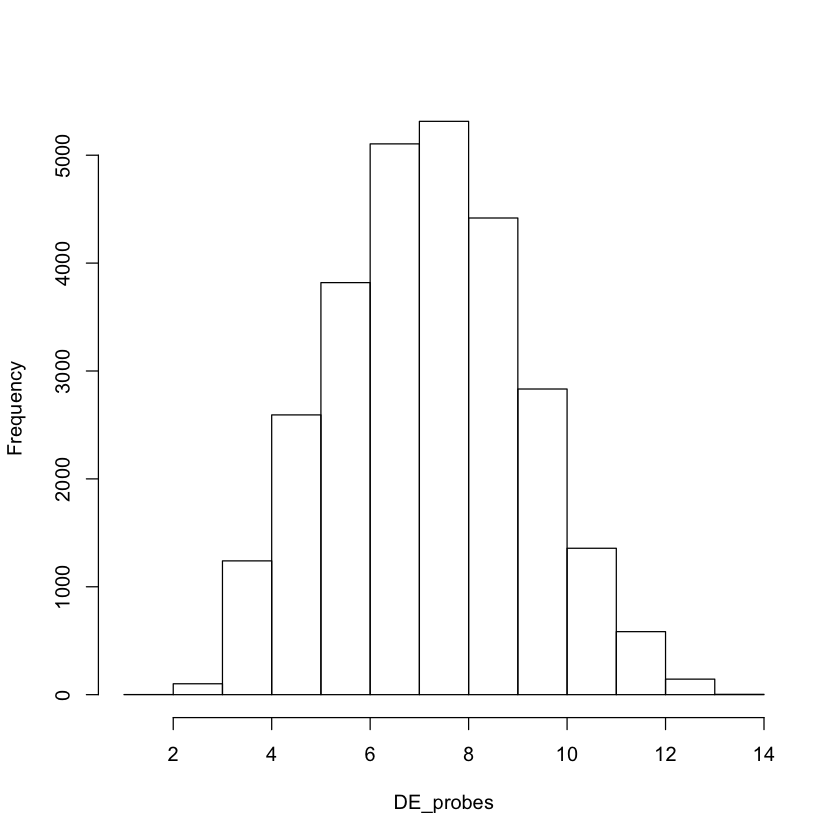

In [140]:
hist(DE_probes,
    main = element_blank())

## Heatmap
Drawing heatmap (from https://jcoliver.github.io/learn-r/008-ggplot-dendrograms-and-heatmaps.html)

In [158]:
DE_probes <- as.data.frame(DE_probes)
DE_probes <- cbind(gene=rownames(DE_probes), DE_probes)
rownames(d) <- c()
DE_probes <- as.matrix(DE_probes)

suppressWarnings(DE_probes_collapsed<-aggregate(DE_probes ~ gene, data=DE_probes, FUN=function(x) mean(as.numeric(x))))
DE_probes_collapsed<-subset(DE_probes_collapsed, select=-c(2))
row.names(DE_probes_collapsed)<-DE_probes_collapsed$gene
DE_probes_collapsed<-subset(DE_probes_collapsed, select=-c(1))
head(DE_probes_collapsed)
dim(DE_probes_collapsed)

,DH5881-CLMD_Mo-8.1.CEL,DH5881-CLMD_Mo-8.2.CEL,DH5881-CLMD_Mo-8.3.CEL,DH5881-CLMD_Mo-8.4.CEL,DH5881-CLMD_Mo-8.5.CEL,DH5881-CLMD_Mo-8.6.CEL,DH5881-CLMD_Mo-8.7.CEL,DH5881-CLMD_Mo-8.8.CEL
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Abca1,382,318,651,873,107,90,419,210
Abca1.1,133,159,140,250,250,199,124,144
Abca1.2,690,522,515,953,608,246,605,545
Abca3,1497,1414,1254,1072,2156,1990,2003,1773
Abcc5,1761,1692,1524,1329,2475,2368,2474,2277
Abcd2,796,753,1135,812,1199,955,1345,1009


[1] 3439    8

In [188]:
c <-c()
for (col in colnames(DE_probes_collapsed)) {
    c<-c(c, sub(".CEL", "", col))
}
colnames(DE_probes_collapsed)<-c

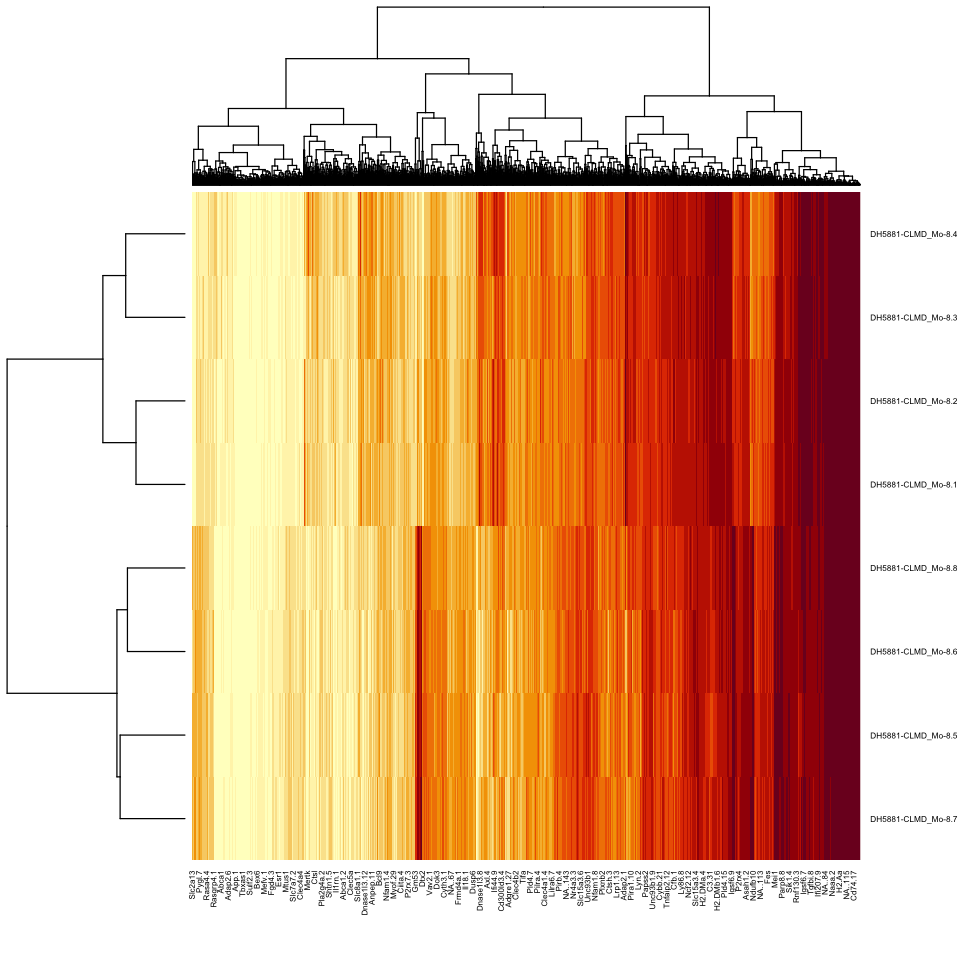

In [189]:
options(repr.plot.width=8, repr.plot.height=8)
heatmap(as.matrix(t(DE_probes_collapsed)), cexRow=0.5)

In [135]:
write.table(subset(table, P.Value < 0.05), file="control_vs_helpless.tsv",sep="\t")

In [190]:
suppressWarnings(back_genes_idx <- genefilter::genefinder(palmieri_final, as.character(DE_genes), method = "manhattan", scale = "none"))

In [191]:
back_genes_idx <- sapply(back_genes_idx, function(x)x$indices)

In [192]:
back_genes <- featureNames(palmieri_final)[back_genes_idx]
back_genes <- setdiff(back_genes, DE_genes)

In [193]:
intersect(back_genes, DE_genes)

character(0)

In [194]:
length(back_genes)

[1] 7308

### DE genes for background-matching
> When comparing the “background gene” curve to the “foreground gene” curve, we see a similar curve shape, indicating a sensible background matching. Note that the right-shift of the “foreground-gene” curve in comparison to the “background-gene” curve indicates that DE-genes are generally very highly expressed, so that it wasn’t possible to find background-genes with exactly equal overall expression distribution.

> The “all gene” curve has the leftmost curve maximum; this can be explained by a high number of lowly expressed genes in all samples and shows that a background matching is sensible in order to avoid biases.

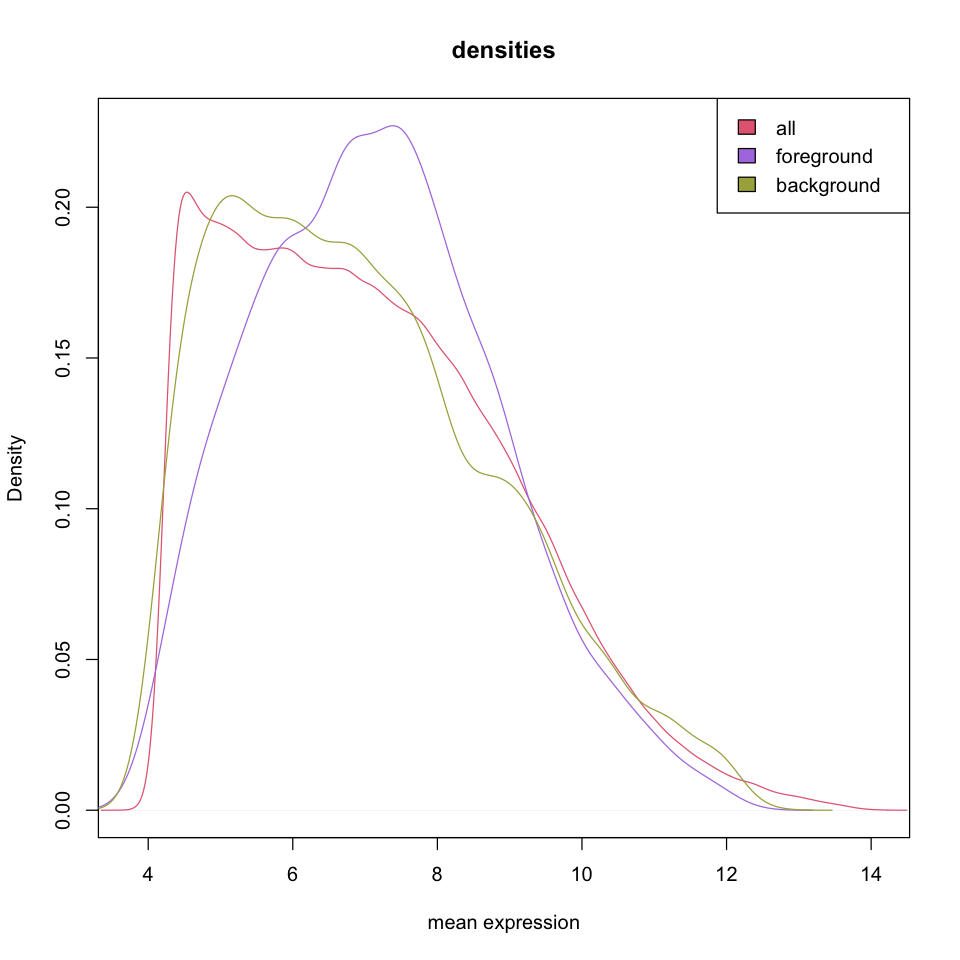

In [609]:
multidensity(list(
        all = table[,"AveExpr"] ,
        foreground = table[DE_genes , "AveExpr"],
        background = table[rownames(table) %in% back_genes, "AveExpr"]),
        col = c("#e46981", "#ae7ee2", "#a7ad4a"),
     xlab = "mean expression")

In [193]:
DE_symbols<-unique(mapIds(mta10probeset.db, 
      keys = DE_genes, 
      keytype = "PROBEID",
      column = "SYMBOL"))

'select()' returned 1:1 mapping between keys and columns


In [179]:
writeLines(DE_symbols, file("de.txt"))

## Enrichment analysis

[Enrichr link](https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=f17013c225bf20ec4870a24fb7ac4d5e) for differentially expressed genes with adjusted p-value more that 0.01

In [214]:
dbs <- c("WikiPathways_2019_Mouse", "KEGG_2019_Mouse", "GO_Molecular_Function_2018", "GO_Cellular_Component_2018", "GO_Biological_Process_2018", "Mouse_Gene_Atlas")
enriched <- enrichr(DE_symbols, dbs)

Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
  Querying KEGG_2019_Mouse... Done.
  Querying GO_Molecular_Function_2018... Done.
  Querying GO_Cellular_Component_2018... Done.
  Querying GO_Biological_Process_2018... Done.
  Querying Mouse_Gene_Atlas... Done.
Parsing results... Done.


In [209]:
head(subset(enriched[["WikiPathways_2019_Mouse"]], select=-c(5,6)), 10)

Term,Overlap,P.value,Adjusted.P.value,Odds.Ratio,Combined.Score,Genes
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Microglia Pathogen Phagocytosis Pathway WP3626,19/41,7.858156e-18,1.383035e-15,13.937282,548.91958,C1QB;LYN;VAV3;C1QA;FCER1G;NCF1;SYK;NCF2;CYBB;PIK3CB;TREM3;PIK3R6;SIGLECE;VAV2;FCGR1;HCK;TYROBP;PLCG2;C1QC
TYROBP Causal Network WP3625,18/58,2.552824e-13,2.246486e-11,9.333679,270.64314,NRROS;GPX1;IGSF6;NCF2;IL18;RNASE6;CAPG;CXCL16;C3;LYL1;TYROBP;SLC7A7;MAF;ADAP2;SH2B3;TMEM106A;IL13RA1;C1QC
Type II interferon signaling (IFNG) WP1253,10/34,9.831347e-08,5.767724e-06,8.845644,142.72538,CXCL10;CXCL9;CIITA;GBP2B;SPI1;STAT1;IFNGR2;IL1B;PRKCD;CYBB
Chemokine signaling pathway WP2292,22/190,3.867265e-07,1.701597e-05,3.482390,51.41940,LYN;VAV3;CXCL9;NCF1;STAT1;PRKCD;ARRB1;PIK3CB;GNG12;CXCL2;CXCL16;VAV2;NFKBIA;FGR;TIAM1;CXCL10;HCK;PAK1;CCL9;CXCL12;GNGT2;CCL6
ApoE and miR-146 in inflammation and atherosclerosis WP3592,5/8,2.062860e-06,7.261268e-05,18.796992,246.07927,SPI1;APOE;TLR4;TLR2;NFKB2
Statin Pathway WP1,6/19,2.474441e-05,7.258359e-04,9.497428,100.73837,ABCA1;SCARB1;LRP1;LPL;APOE;LDLR
Oxidative Damage WP1496,8/42,6.214043e-05,1.562388e-03,5.728607,55.48794,C1QB;C4B;C1QA;CDKN1A;C3AR1;NFKBIE;TNF;C1QC
IL-5 Signaling Pathway WP151,10/69,8.939946e-05,1.966788e-03,4.358723,40.63374,LYN;NFKBIA;HCK;SYK;STAT1;PRKCD;ALOX5AP;BTK;PLA2G4A;CSF2RB
Iron Homeostasis WP1596,5/15,9.108814e-05,1.781279e-03,10.025063,93.27000,FTL1;HFE;SLC40A1;IL6RA;TNF


In [210]:
head(subset(enriched[["KEGG_2019_Mouse"]], select=-c(5,6)), 10)

Term,Overlap,P.value,Adjusted.P.value,Odds.Ratio,Combined.Score,Genes
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Osteoclast differentiation,33/128,1.676403e-20,5.079502e-18,7.753759,353.0678,SIRPB1B;PIRA1;LILRA6;CSF1R;SIRPB1A;SPI1;PIRA2;NCF1;NCF2;PIRA6;PIK3CB;PIRB;TNF;PLCG2;SIRPA;GM14548;GM9733;SYK;GM15448;STAT1;IFNGR2;GAB2;LILRB4A;NFKB2;FCGR1;NFKBIA;FCGR3;TYROBP;FCGR4;IL1B;BTK;FCGR2B;SIRPB1C
Tuberculosis,33/178,7.288340e-16,1.104184e-13,5.575737,194.3428,CAMK2B;CIITA;H2-DMA;NOD2;TNF;CTSS;C3;H2-DMB2;LAMP1;CLEC7A;H2-DMB1;MRC1;PLK3;CD74;H2-EB1;FCER1G;SYK;STAT1;IFNGR2;IL18;H2-AA;TIRAP;FCGR1;TLR1;FCGR3;FCGR4;IL1B;TLR9;CLEC4E;FCGR2B;TLR4;H2-AB1;TLR2
Leishmaniasis,21/67,2.052868e-15,2.073397e-13,9.426551,318.8016,H2-EB1;NCF1;NCF2;STAT1;IFNGR2;H2-DMA;CYBB;PTGS2;TNF;H2-AA;FCGR1;C3;NFKBIA;H2-DMB2;FCGR3;FCGR4;IL1B;H2-DMB1;TLR4;TLR2;H2-AB1
NOD-like receptor signaling pathway,30/205,9.049482e-12,6.854983e-10,4.401247,111.9163,NLRP1B;NOD2;MEFV;TNF;CXCL2;OAS1G;TRPM2;NAMPT;NLRP3;IKBKE;CTSB;GBP5;GBP2B;IFI207;IFI204;STAT1;PRKCD;IL18;CYBB;NFKBIA;P2RX7;NAIP2;NAIP5;AIM2;OAS2;IL1B;IRF7;TLR4;NAIP1;BIRC3
C-type lectin receptor signaling pathway,22/112,1.524996e-11,9.241476e-10,5.907626,147.1380,CLEC4B2;PLK3;CLEC4B1;FCER1G;SYK;CLEC4N;STAT1;PRKCD;PIK3CB;PTGS2;TNF;NFKB2;NFKBIA;PAK1;CLEC4D;CLEC7A;IL1B;MAPKAPK2;PLCG2;NLRP3;CLEC4E;IKBKE
Staphylococcus aureus infection,20/95,3.403081e-11,1.718556e-09,6.331619,152.6158,C1QB;C1QA;H2-EB1;H2-DMA;PTAFR;FPR1;FPR2;H2-AA;C4B;FCGR1;C3;H2-DMB2;FCGR3;FCGR4;H2-DMB1;C3AR1;FCGR2B;CFB;H2-AB1;C1QC
Phagosome,27/180,5.595053e-11,2.421859e-09,4.511278,106.4957,SCARB1;NCF1;ITGB5;NCF2;H2-DMA;CTSS;C3;H2-DMB2;LAMP1;CLEC7A;CTSL;H2-DMB1;MRC1;CD36;MSR1;H2-EB1;CYBB;H2-AA;FCGR1;FCGR3;PIKFYVE;FCGR4;ITGA5;FCGR2B;TLR4;H2-AB1;TLR2
Toll-like receptor signaling pathway,20/99,7.527471e-11,2.851030e-09,6.075796,141.6260,CD40;CXCL9;STAT1;LY96;PIK3CB;TNF;TIRAP;NFKBIA;TLR1;CXCL10;IL1B;TLR9;IRF7;TLR8;IRF5;TLR7;IKBKE;TLR4;TLR3;TLR2
Fc gamma R-mediated phagocytosis,18/87,4.433423e-10,1.492586e-08,6.222453,134.0110,VAV3;LYN;NCF1;SYK;MYO10;PRKCD;PLA2G4A;ASAP1;PIK3CB;GAB2;PLD1;VAV2;FCGR1;HCK;PAK1;PLCG2;GM11787;FCGR2B


In [211]:
head(subset(enriched[["GO_Molecular_Function_2018"]], select=-c(5,6)), 10)

Term,Overlap,P.value,Adjusted.P.value,Odds.Ratio,Combined.Score,Genes
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Toll-like receptor binding (GO:0035325),5/9,4.514101e-06,0.005195730,16.708438,205.65254,TLR1;UNC93B1;CD36;TIRAP;TLR2
lipoprotein particle receptor activity (GO:0030228),6/15,5.115280e-06,0.002943844,12.030075,146.56576,SCARB1;LRP1;CD36;LRP8;LDLR;CXCL16
purinergic nucleotide receptor activity (GO:0001614),6/15,5.115280e-06,0.001962562,12.030075,146.56576,P2RX7;P2RY13;P2RX5;P2RX4;P2RY14;PTAFR
low-density lipoprotein receptor activity (GO:0005041),5/13,4.126153e-05,0.011873004,11.567380,116.77941,LRP1;CD36;LRP8;LDLR;CXCL16
phosphotyrosine residue binding (GO:0001784),6/30,3.964628e-04,0.091265747,6.015038,47.11536,FGR;HCK;SYK;SH3BP2;PLCG2;VAV2
protein tyrosine kinase activity (GO:0004713),14/148,4.292982e-04,0.082353713,2.844950,22.05792,LYN;CSF1R;FLT1;SYK;CSF2RB;MERTK;CSF2RA;FGR;HCK;ERBB3;FES;AXL;BTK;MET
scavenger receptor activity (GO:0005044),5/21,5.230050e-04,0.085996964,7.160759,54.10612,MSR1;SCARB1;LRP1;CD36;CXCL16
Rho guanyl-nucleotide exchange factor activity (GO:0005089),8/60,7.968502e-04,0.114646825,4.010025,28.61090,VAV3;TIAM1;FGD4;TRIO;ARHGEF37;ARHGEF17;ARHGEF10L;VAV2
protein phosphorylated amino acid binding (GO:0045309),6/35,9.412594e-04,0.120376613,5.155747,35.92675,FGR;HCK;SYK;SH3BP2;PLCG2;VAV2


In [212]:
head(subset(enriched[["GO_Cellular_Component_2018"]], select=-c(5,6)), 10)

Term,Overlap,P.value,Adjusted.P.value,Odds.Ratio,Combined.Score,Genes
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
tertiary granule (GO:0070820),27/165,7.004550e-12,3.124029e-09,4.921394,126.40336,CYFIP1;CSTB;ASAH1;CLEC12A;PTAFR;FPR1;FPR2;CFP;PLD1;CTSS;CST3;TRPM2;LAMP1;CLEC5A;SIRPA;CTSH;STOM;CD33;FCER1G;CD300A;SLC11A1;CYBB;MCEMP1;CEACAM1;CLEC4D;DOK3;TARM1
tertiary granule membrane (GO:0070821),17/74,2.375357e-10,5.297046e-08,6.909165,153.11195,FCER1G;CLEC12A;CD300A;SLC11A1;PTAFR;CYBB;MCEMP1;FPR2;PLD1;TRPM2;CEACAM1;CLEC4D;CLEC5A;TARM1;SIRPA;STOM;CD33
lysosome (GO:0005764),41/423,9.572176e-10,1.423064e-07,2.915089,60.53763,SCARB1;ASAH1;GRN;LRP1;UNC93B1;LRRK2;HEXA;SDC3;CTSZ;ARRB1;IFI30;PLD1;CTSS;TRPM2;DRAM1;LAMP1;CTSL;ANPEP;PSAP;CTSH;ACP2;SLC15A3;LDLR;CTSC;CTSB;CD74;NAPSA;SZT2;SLC11A1;GFAP;CLCN7;MARCH1;HCK;VCAN;P2RX4;NAAA;TLR9;TLR7;HPSE;TLR3;LGMN
lytic vacuole (GO:0000323),25/184,2.404418e-09,2.680927e-07,4.086303,81.09659,GRN;UNC93B1;LRRK2;CTSZ;IFI30;CTSS;TRPM2;DRAM1;LAMP1;CTSL;PSAP;CTSH;ACP2;LDLR;CTSC;CTSB;NAPSA;SLC11A1;GFAP;MARCH1;HCK;TLR9;TLR7;HPSE;LGMN
endolysosome (GO:0036019),9/21,9.670919e-09,8.626459e-07,12.889366,237.86220,CTSL;TLR9;TLR8;TLR7;LDLR;CTSS;TLR3;CTSB;LGMN
integral component of plasma membrane (GO:0005887),88/1464,3.963020e-08,2.945845e-06,1.807798,30.81152,APP;CD40;CSF3R;FLT1;BMPR2;PLXND1;CD81;HFE;PTPRO;SLC40A1;GRIK1;SLC7A11;TNF;SLC2A6;PKD1;SLC8A1;MILR1;ADGRE1;LAMP1;MRC1;CLEC5A;CCRL2;C3AR1;CD36;CD33;IL13RA1;FCER1G;GPR35;IFNGR2;SLC2A13;SLC11A1;ABCC5;CD180;CYBB;TLR1;MMP14;CEACAM1;SLC7A7;TYROBP;SLC7A8;TLR8;CD302;GPRC5C;MET;TLR4;TNFRSF21;TLR3;ENG;LY6E;TLR2;CSF1R;IGSF6;SGMS1;LRP1;SLC43A2;PLPPR3;PTAFR;FPR1;CLCNKA;CSF2RB;FPR2;CSF2RA;TRPM2;P2RY6;HRH3;ERBB3;PLXNA1;LRRC8D;STOM;TNFRSF14;LDLR;ABCA1;P2RY13;MSR1;KCNJ10;P2RY14;MERTK;CALHM6;P2RX7;ATP4A;P2RX4;TSPAN13;SELL;AXL;PLXNB2;LTBR;FCGR2B;ADGRL3
phagocytic vesicle (GO:0045335),15/84,1.012594e-07,6.451669e-06,5.370569,86.49614,ABCA1;NCF1;ITGB5;SYK;NCF2;ANXA3;UNC93B1;HFE;SLC11A1;CYBB;PLD4;RAB32;TLR9;TLR7;CD36
specific granule membrane (GO:0035579),15/92,3.502421e-07,1.952600e-05,4.903563,72.88971,CLEC12A;CYBB;MCEMP1;FPR2;SCAMP1;PLD1;TRPM2;CEACAM1;CLEC4D;CLEC5A;TARM1;C3AR1;STOM;CD36;CD33
specific granule (GO:0042581),20/161,4.197401e-07,2.080045e-05,3.736048,54.85875,CYFIP1;CLEC12A;ANXA3;CTSZ;CYBB;MCEMP1;FPR2;SCAMP1;CFP;PLD1;TRPM2;CEACAM1;CLEC4D;CLEC5A;TARM1;C3AR1;STOM;HPSE;CD36;CD33


In [213]:
head(subset(enriched[["GO_Biological_Process_2018"]], select=-c(5,6)), 10)

Term,Overlap,P.value,Adjusted.P.value,Odds.Ratio,Combined.Score,Genes
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
neutrophil activation involved in immune response (GO:0002283),55/484,1.519027e-15,7.751593e-12,3.417635,116.61212,CYFIP1;HFE;CTSZ;PYGL;CTSS;HK3;LAMP1;ANPEP;CLEC5A;C3AR1;CTSH;SIRPA;CD36;CD33;CTSC;CTSB;FCER1G;SYK;ANXA3;CD300A;NFAM1;SLC11A1;PRKCD;CYBB;MCEMP1;AMPD3;SCAMP1;FGR;CEACAM1;CLEC4D;TYROBP;DOK3;DNASE1L3;TLR2;CSTB;ASAH1;GRN;CLEC12A;MVP;PTAFR;FPR1;FPR2;CFP;PLD1;C3;PLAC8;CST3;TRPM2;PSAP;STOM;GCA;SELL;TARM1;HPSE;CD68
neutrophil degranulation (GO:0043312),53/480,1.678649e-14,4.283074e-11,3.320802,105.32987,CYFIP1;HFE;CTSZ;PYGL;CTSS;HK3;LAMP1;ANPEP;CLEC5A;C3AR1;CTSH;SIRPA;CD36;CD33;CTSC;CTSB;FCER1G;ANXA3;CD300A;NFAM1;SLC11A1;PRKCD;CYBB;MCEMP1;AMPD3;SCAMP1;FGR;CEACAM1;CLEC4D;TYROBP;DOK3;TLR2;CSTB;ASAH1;GRN;CLEC12A;MVP;PTAFR;FPR1;FPR2;CFP;PLD1;C3;PLAC8;CST3;TRPM2;PSAP;STOM;GCA;SELL;TARM1;HPSE;CD68
neutrophil mediated immunity (GO:0002446),53/488,3.308315e-14,5.627444e-11,3.266363,101.38709,CYFIP1;HFE;CTSZ;PYGL;CTSS;HK3;LAMP1;ANPEP;CLEC5A;C3AR1;CTSH;SIRPA;CD36;CD33;CTSC;CTSB;FCER1G;ANXA3;CD300A;NFAM1;SLC11A1;PRKCD;CYBB;MCEMP1;AMPD3;SCAMP1;FGR;CEACAM1;CLEC4D;TYROBP;DOK3;TLR2;CSTB;ASAH1;GRN;CLEC12A;MVP;PTAFR;FPR1;FPR2;CFP;PLD1;C3;PLAC8;CST3;TRPM2;PSAP;STOM;GCA;SELL;TARM1;HPSE;CD68
inflammatory response (GO:0006954),35/253,8.850500e-13,1.129103e-09,4.160599,115.46966,CSF1R;CD40;CXCL9;NRROS;FPR1;FPR2;AOAH;PIK3CB;NOD2;MEFV;AIF1;TNF;CXCL2;PRDX5;CCRL2;C3AR1;NLRP3;TNFRSF14;LYN;SYK;SLC11A1;NFAM1;CD180;IL18;CYBB;NFKB2;CXCL10;IL1B;MAPKAPK2;TLR8;SIGLEC1;LTBR;FCGR2B;TLR4;TNFRSF21
pattern recognition receptor signaling pathway (GO:0002221),16/49,2.251759e-12,2.298145e-09,9.820470,263.37821,UNC93B1;CD180;LY96;CTSS;TLR1;CTSL;MAPKAPK2;TLR9;TLR8;TLR7;CD36;TLR4;TLR3;CTSB;TLR2;LGMN
cytokine-mediated signaling pathway (GO:0019221),56/634,2.930109e-11,2.492057e-08,2.656483,64.42875,IFITM3;CDKN1A;CIITA;IL1RN;CD40;CXCL9;CSF3R;IFITM2;HFE;F13A1;IL27;PIK3CB;IFI30;TNF;CXCL2;IL18BP;CD36;IL13RA1;SYK;GPR35;IFNGR2;IL1R2;PRKCD;IL18;GAB2;HCK;CEACAM1;AIM2;OAS2;IL1B;IRF7;IRF5;LCP1;TNFRSF21;BIRC3;CAMK2B;CSF1R;PTAFR;EBI3;FPR1;CSF2RB;NOD2;PTGS2;LRP8;CSF2RA;HMOX1;TNFRSF14;CD300LF;VCAM1;STAT1;FN1;NFKBIA;CXCL10;CXCL12;BCL6;LTBR
toll-like receptor signaling pathway (GO:0002224),19/87,5.358885e-11,3.906627e-08,6.568144,155.33452,UNC93B1;CD180;LY96;CTSS;TIRAP;TLR1;CTSL;MAPKAPK2;TLR9;BTK;TLR8;TLR7;CD36;TLR4;TLR3;CTSB;TLR2;BIRC3;LGMN
regulation of inflammatory response (GO:0050727),25/167,3.017021e-10,1.924482e-07,4.502274,98.69696,LPL;NOD2;METRNL;MEFV;PTGS2;PLA2G7;SBNO2;NLRP3;APOE;PRKCD;IL18;ACOD1;NR1H3;KLF4;NFKBIA;HCK;BCL6;TLR9;TLR7;GHRL;TLR4;DNASE1L3;TLR3;BIRC3;TLR2
response to lipopolysaccharide (GO:0032496),24/156,3.854438e-10,2.185466e-07,4.626952,100.29671,SCARB1;CD274;MEF2C;CD40;CXCL9;GCH1;SLC11A1;ACOD1;LY96;NR1H3;CXCL2;TIRAP;CXCL10;SBNO2;AXL;ZC3H12A;MAPKAPK2;ADAM9;NLRP3;TNFRSF14;LTBR;TRIB1;TLR4;TNFRSF21


In [215]:
head(subset(enriched[["Mouse_Gene_Atlas"]], select=-c(5,6)), 10)

Term,Overlap,P.value,Adjusted.P.value,Odds.Ratio,Combined.Score,Genes
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
macrophage_peri_LPS_thio_7hrs,82/707,2.335520e-23,2.242099e-21,3.488211,181.77496,IL1RN;CD40;NRP2;TRIM30D;CTSZ;MS4A7;SLC7A11;MS4A4C;TNF;SLC2A6;CXCL2;IL18BP;CXCL16;HK3;RASSF4;NAMPT;ZC3H12A;CCRL2;IKBKE;IL13RA1;OASL2;CTSB;TGM2;ARRDC4;BATF2;IFNGR2;ARHGEF17;ABCC5;MYOF;IL18;TRAFD1;CYBB;RAB32;MMP14;RASA4;OAS2;IL1B;TLR9;IRF7;TLR7;IRF5;ITGA5;CLEC4E;MOCS1;MET;ATF3;TLR3;TLR2;CD274;SLFN5;IGSF6;SLFN4;PTAFR;CAPG;MEFV;PTGS2;CSF2RA;MS4A6D;ADAP2;DRAM1;TMEM67;ESD;TIFA;SH3BP2;SLAMF8;PLXNA1;SLC15A3;F10;GCH1;MLKL;IFI204;STAT1;PLK2;MERTK;PARP12;HIPK2;NFKB2;CLCN7;CXCL10;P2RX4;NR4A3;RNF149
dendritic_cells_myeloid_CD8a-,32/188,2.499350e-14,1.199688e-12,5.119181,160.33357,SIRPB1A;DOCK4;CXCL9;CLEC4A3;LY6I;HFE;H2-DMA;ROGDI;MEFV;TIFAB;KYNU;CTSH;PPFIA4;TNS3;PLEKHA1;GPR35;TRAFD1;TBC1D9;NAV1;CBFA2T3;H2-AA;FGR;CYP4F16;CCDC88A;TREML4;LPCAT2;PLBD1;DNA2;GM6377;DNASE1L3;BEX6;SKAP2
macrophage_bone_marrow_24h_LPS,56/551,1.009923e-13,3.231753e-12,3.056643,91.46618,SIRPB1A;PID1;WDR48;LY6I;NCF1;CLEC4N;LST1;MS4A7;SAT1;IL18BP;SIGLECE;CXCL16;SPIC;GNGT2;BC028528;SIRPA;ACP2;APOBEC1;FCER1G;ACSL1;IFNGR2;SLC11A1;KLRA2;ABCC5;CYBB;GAB2;FCGR1;NAIP2;FCGR3;VCAN;CLEC4D;NINJ1;BLVRB;PLEKHO1;CLEC4E;B4GALT6;CD274;CLEC4A3;SLC43A2;SDC3;EBI3;LY96;AOAH;CFP;CLN8;MS4A6D;PRDX5;P2RY6;ADAP2;HMOX1;RNF130;MSR1;PILRA;BCL6;SIGLEC1;TGFBI
macrophage_bone_marrow_6hr_LPS,65/730,4.683138e-13,1.123953e-11,2.677928,76.02540,CYFIP1;IL1RN;CD40;PID1;CSF3R;PRKAG2;MS4A4C;DUSP16;SLC2A6;IL18BP;SIGLECE;PSTPIP2;RASSF4;NAMPT;ZC3H12A;IKBKE;CTSC;OASL2;TPD52;BATF2;IFNGR2;IL18;CYBB;GBGT1;FCGR1;HCK;FCGR3;FCGR4;IL1B;MAPKAPK2;TLR8;LCP1;CLEC4E;MOCS1;SLFN5;SDC3;EBI3;FPR1;LY96;DTX2;FPR2;AOAH;CFP;PTGS2;MS4A6D;PIK3R6;MS4A6C;ENOX2;CCL9;TIFA;STOM;TNFRSF14;SLC15A3;LDLR;LYN;MSR1;SLC16A10;PILRA;PARP12;HIPK2;CXCL10;NR4A3;LPCAT2;SIGLEC1;FCGR2B
macrophage_peri_LPS_thio_1hrs,53/598,8.998210e-11,1.727656e-09,2.665527,61.65739,CYFIP1;APP;NRP2;TNFAIP2;TNF;CXCL2;CTSS;TMEM191C;HK3;CTSL;RASGEF1B;CCRL2;NFKBIZ;CTSB;TGIF1;KDM6B;DUSP1;CD300A;IFNGR2;SLC11A1;ABCC5;MYOF;RENBP;MPEG1;RASA4;PLEKHO1;ITGA5;CD302;ATF3;TLR13;CSTB;IGSF6;PIRA2;LYZ1;ATP1A3;CLN8;CSF2RA;MS4A6D;FGD4;PAK1;CLEC7A;PSAP;PLXNA1;NLRP3;STOM;5031439G07RIK;PLK2;SLC16A10;HIPK2;NFKBIA;RNF149;SESTD1;RGL1
macrophage_peri_LPS_thio_0hrs,34/353,3.089276e-08,4.942842e-07,2.896760,50.09293,PID1;PIRA2;LRP1;HEXA;CLN8;CSF2RA;HK3;CTSL;CLEC7A;ANPEP;PSAP;PLXNA1;5031439G07RIK;CTSB;MPP1;PLEKHG1;CD300A;SLC11A1;NFAM1;ABCC5;SLC16A10;RENBP;MPEG1;HIPK2;P2RX4;SESTD1;NINJ1;PLEKHO1;HPSE;RGL1;CD68;SKAP2;LGMN;TLR13
dendritic_cells_lymphoid_CD8a+,20/142,5.168815e-08,7.088661e-07,4.235942,71.07079,CXCL9;ZFP516;H2-DMA;TBC1D9;NAV1;CBFA2T3;H2-AA;TRPM2;CCDC88A;TIFAB;FMNL2;TREML4;NAAA;PLBD1;DNA2;TRIB1;WDFY4;GM6377;DNASE1L3;TLR3
macrophage_bone_marrow_0hr,22/180,1.493358e-07,1.792029e-06,3.675856,57.77369,VAV3;C1QB;CSF1R;CLEC4B1;SLC43A2;LPL;FRMD4B;METRNL;CFP;CTTNBP2NL;FGD4;P2RY6;EVI2A;MRC1;C3AR1;CD300LD;B4GALT6;TLR4;TMEM106A;SKAP2;TLR13;C1QC
microglia,14/90,1.543226e-06,1.646107e-05,4.678363,62.60414,C1QB;ABCA1;C1QA;CLEC4A2;CLEC4N;MS4A7;FPR1;SLC7A11;AMPD3;MS4A6D;RASSF4;C3AR1;CTSC;C1QC
